<a href="https://colab.research.google.com/github/Satish-Dwivedi/Bank_dataset/blob/main/kaggle_data_set_sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [1]:
import pandas as pd
import nltk
nltk.download('punkt_tab')
import re
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
eng_stop_words = stopwords.words('english')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Read The Data**

In [2]:
column_names = ["id", "game", "sentiment", "text"]
data=pd.read_csv('/content/twitter_training.csv',header=None, names=column_names)
data.head(10)


,id,game,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


In [3]:
data.shape

(74682, 4)

In [4]:
data.isnull().sum()

,0
id,0
game,0
sentiment,0
text,686


In [5]:
data.fillna("", inplace=True)

In [6]:
data.isnull().sum()

,0
id,0
game,0
sentiment,0
text,0


**Preprocess Data**

In [7]:
ps=PorterStemmer()
corpus=set()
def preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub("<[^>]*>", "", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Keep only letters
    text = text.strip()  # Remove leading/trailing spaces
    words = text.split()  # Tokenize text

    words = [w for w in words if w not in eng_stop_words]  # Remove stopwords
    words = [ps.stem(word) for word in words]  # Apply stemming
    text = " ".join(words)  # Convert list back to string
    return text

In [8]:
data["clean_text"] = data["text"].apply(preprocess)
data.tail()


,id,game,sentiment,text,clean_text
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realiz window partit mac like year behind nvid...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realiz mac window partit year behind nvidia dr...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realiz window partit mac year behind nvidia dr...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,realiz window partit mac like year behind nvid...
74681,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...,like window partit mac like year behind driver...


<ipython-input-9-aecdd1ff7281>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["sentiment"], palette=colors)


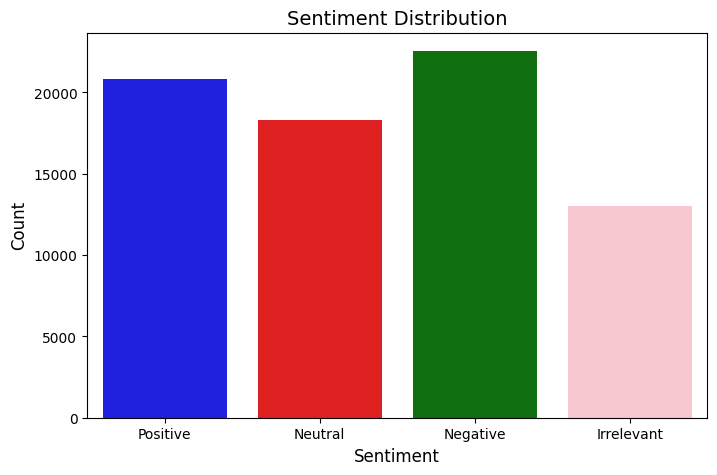

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["blue", "red", "green","pink"]

plt.figure(figsize=(8,5))
sns.countplot(x=data["sentiment"], palette=colors)
plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


**tokenize the each sentence into words**

In [10]:
token=[word_tokenize(sentence.lower()) for sentence in data["clean_text"]]
token[:5]

[['im', 'get', 'borderland', 'murder'],
 ['come', 'border', 'kill'],
 ['im', 'get', 'borderland', 'kill'],
 ['im', 'come', 'borderland', 'murder'],
 ['im', 'get', 'borderland', 'murder']]

**all these pass to w2v**


In [11]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=token,vector_size=100,window=5,min_count=1,sg=0)

In [12]:
model.save("Word2Vec_Sentiment_Alaysis")
w2v_model=Word2Vec.load("Word2Vec_Sentiment_Alaysis")

**you will get each sentence has words as vectors**

In [13]:
import numpy as np

def get_sentence_embedding(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv.key_to_index]

    if len(word_vectors) == 0:  # Handle empty case
        return np.zeros(model.vector_size)

    return np.mean(word_vectors, axis=0)


**words as vectors to sentence vector**



In [14]:
X_vectors = np.array([get_sentence_embedding(text, w2v_model) for text in data["text"] if isinstance(text, str)])



**train test split**

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_vectors,data["sentiment"],test_size=0.2,random_state=42)
print(len(x_train), len(x_test))


59745 14937


**load the model pass train vectors and train labels**

In [16]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
lr = LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression()

**pass test vectors and get the accuracy**

In [17]:
y_pred = lr.predict(x_test)
y_pred

array(['Negative', 'Neutral', 'Negative', ..., 'Neutral', 'Neutral',
       'Neutral'], dtype=object)

In [18]:
from sklearn.metrics import accuracy_score
# print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.43462542679252864


In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print("New Accuracy:", accuracy_score(y_test, y_pred))


New Accuracy: 0.6153176675369887


**unseen data
           preprocess
           tokenize
           words as vectors
           sentence vector
           pass to model ==== yes or no**

In [23]:
def predict_sentiment(text, model, w2v_model):
    clean_text = preprocess(text)
    sentence_vector = get_sentence_embedding(clean_text, w2v_model).reshape(1, -1)
    return model.predict(sentence_vector)[0]

new_text = "This product is very bad!"
print("Predicted Sentiment:", predict_sentiment(new_text, rf, w2v_model))


Predicted Sentiment: Negative


In [29]:
def predict_sentiment(text, model, w2v_model):
    clean_text = preprocess(text)
    sentence_vector = get_sentence_embedding(clean_text, w2v_model).reshape(1, -1)
    return model.predict(sentence_vector)[0]

new_text = "I am a imotional person how to get out from this weakness."
print("Predicted Sentiment:", predict_sentiment(new_text, rf, w2v_model))


Predicted Sentiment: Negative
